# MobileNet V1 SSD network for Object Detection.

### Implementation from scratch without using TFOD API

Dataset Link : https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection

### 1. Training Phase

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Dataset")
!unzip fruits_dataset.zip

Archive:  fruits_dataset.zip
replace test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
!ls

checkpoint  fruits_dataset.zip	Indian_Number_plates.json  test_zip  train_zip


In [66]:
#neccessary module imports
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, ZeroPadding2D,DepthwiseConv2D, ReLU, Input,AveragePooling2D, GlobalAveragePooling2D,Dense,Dropout
from tensorflow.keras.activations import sigmoid,relu
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import xml.etree.ElementTree as ET
import glob
import numpy as np
np.random.seed(42)
import cv2

In [5]:
#helper functions for parsing the xml content and getting annotation content
def FindNumberBoundingBoxes(root):
    index = 0
    while True:
        if GetInt('xmin', root, index) == -1:
              break
        index += 1
    return index

def GetInt(name, root, index=0):
      return int(GetItem(name, root, index))

def GetItem(name, root, index=0):
    count = 0
    for item in root.iter(name):
        if count == index:
            return item.text
        count += 1
       # Failed to find "index" occurrence of item.
    return -1

def process_xml(xmlfile):
    tree = ET.parse(xmlfile)
    root = tree.getroot()

    num_boxes = FindNumberBoundingBoxes(root)
    attributes = []

    for index in range(num_boxes):
        # Grab the 'index' annotation.
        xmin = GetInt('xmin', root, index)
        ymin = GetInt('ymin', root, index)
        xmax = GetInt('xmax', root, index)
        ymax = GetInt('ymax', root, index)

        width = GetInt('width', root)
        height = GetInt('height', root)
        filename = GetItem('filename', root) + '.JPEG'
        label = GetItem('name', root)
        
    attributes.append([[xmin,ymin,xmax,ymax],[width],[height],[filename],[label]])
    return attributes

In [6]:
train_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/train_zip/train"
val_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/test_zip/test"

True
True


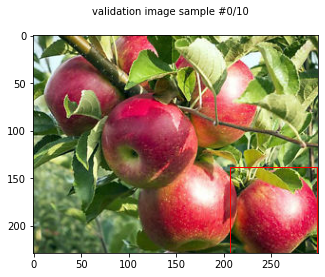

In [7]:
#visualizing the dataset and validating the Ground truth ROI

#showing first ten samples along with bounding box in the dataset
# Training samples visualisation
idx =0
for train_file, train_annotation in zip(glob.glob(train_path+"/*.jpg"),glob.glob(train_path+"/*.xml")):
    #displaying only first 10 images
    if idx<10:
        # Training image processing
        #reading image 
        train_image = Image.open(train_file)
        #reading bounding box xml file and processing to fetch xA,yA,xB,yB
        train_content = process_xml(train_annotation)
        #checking if filename equals the train_image file name
        if(train_annotation.split('\\')[-1].split('.')[0])==(train_file.split('\\')[-1].split('.')[0]):
            xA,yA,xB,yB = train_content[0][0]
            #processing done
            fig,ax = plt.subplots()
            fig.suptitle("Training image sample #{}/10".format(idx), fontsize=10)
            ax.imshow(train_image)
            rect = patches.Rectangle((xA,yA),xB-xA,yB-yA, linewidth=1, edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        idx+=1

        
# Validation samples visualisation
idx1 =0
for val_file, val_annotation in zip(glob.glob(val_path+"/*.jpg"),glob.glob(val_path+"/*.xml")):
    #displaying only first 10 images
    if idx1<10:
        # Training image processing
        #reading image 
        val_image = Image.open(val_file)
        #reading bounding box xml file and processing to fetch xA,yA,xB,yB
        val_content = process_xml(val_annotation)
        #checking if filename equals the train_image file name
        if(val_annotation.split('\\')[-1].split('.')[0])==(val_file.split('\\')[-1].split('.')[0]):
            xA,yA,xB,yB = val_content[0][0]
            #processing done
            fig,ax = plt.subplots()
            fig.suptitle("validation image sample #{}/10".format(idx1), fontsize=10)
            ax.imshow(val_image)
            rect = patches.Rectangle((xA,yA),xB-xA,yB-yA, linewidth=1, edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        idx1+=1
#checking if number of images == number of annotations or not
print(len(glob.glob(train_path+"/*.jpg"))== len(glob.glob(train_path+"/*.xml")))
print(len(glob.glob(val_path+"/*.jpg"))== len(glob.glob(val_path+"/*.xml")))

In [8]:
#now creating 4 lists to store features and labels
LabelDict = {"apple":0,"banana":1, "orange":2}
train_features, train_coordinates, train_labels, val_features,val_coordinates, val_labels = [],[],[],[],[],[]
#creating list of train,val images and xml files
train_images = glob.glob(train_path+"/*.jpg")
val_images = glob.glob(val_path+"/*.jpg")
train_annotations = glob.glob(train_path+"/*.xml")
val_annotations = glob.glob(val_path+"/*.xml")

#helper function for preprocessing
def normalize_annotation(coordinates, original, resized=(150,150)):
    W,H = np.shape(original)[0], np.shape(original)[1]
    #print(coordinates)
    scale_W,scale_H = 224.0/float(W),224.0/float(H)
    coordinates[0],coordinates[2] = coordinates[0]*scale_W,coordinates[2]*scale_W
    coordinates[1],coordinates[3] = coordinates[1]*scale_H,coordinates[3]*scale_H
    #print(coordinates)
    return coordinates
    
    

#processing train dataset
for idx1 in range(1,len(train_images)):
    for idx2 in range(1,len(train_annotations)):
        if train_images[idx1].split('\\')[-1].split('.')[0] == train_annotations[idx2].split('\\')[-1].split('.')[0] :
            #open image
            train_image_content = cv2.imread(train_images[idx1])
            #reshaping the image
            resized_image_content = cv2.resize(train_image_content,(224,224), interpolation = cv2.INTER_AREA)
            #fetching the label and bounding box
            label = process_xml(train_annotations[idx2])[0][-1][0]
            bounding_box = process_xml(train_annotations[idx2])[0][0]
            #normalising labels as per new size
            #original shape of image
            normalised_coordinates = normalize_annotation(bounding_box,train_image_content)
            #now appending the data to corresponding lists
            print("Processed {} out {} images".format(idx1,len(train_images)))
            train_features.append(np.asarray(resized_image_content))
            train_coordinates.append(normalised_coordinates)
            train_labels.append([LabelDict[label]])
            

#processing val dataset
for idx1 in range(1,len(val_images)):
    for idx2 in range(1,len(val_annotations)):
        if val_images[idx1].split('\\')[-1].split('.')[0] == val_annotations[idx2].split('\\')[-1].split('.')[0] :
            #open image
            val_image_content = cv2.imread(val_images[idx1])
            #reshaping the image
            resized_image_content = cv2.resize(val_image_content,(224,224) ,interpolation = cv2.INTER_AREA)
            #fetching the label and bounding box
            label = process_xml(val_annotations[idx2])[0][-1][0]
            bounding_box = process_xml(val_annotations[idx2])[0][0]
            #normalising labels as per new size
            #original shape of image
            normalised_coordinates = normalize_annotation(bounding_box,val_image_content)
            #now appending the data to corresponding lists
            print("Processed {} out {} images".format(idx1,len(val_images)))
            val_features.append(np.asarray(resized_image_content))
            val_coordinates.append(normalised_coordinates)
            val_labels.append([LabelDict[label]])

    
# #converting each list to numpy array
train_features = np.asarray(train_features)
train_coordinates = np.asarray(train_coordinates)
#converting to one hot encoded
train_labels = tf.keras.utils.to_categorical(
    train_labels, num_classes=3, dtype='float32'
)
val_features = np.asarray(val_features)
val_coordinates = np.asarray(val_coordinates)
#converting to one hot_encoded
val_labels = tf.keras.utils.to_categorical(
    val_labels, num_classes=3, dtype='float32'
)
#printing the final shapes of dataset
print("Shape of training features", np.shape(train_features))
print("Shape of training coordinates",np.shape(train_coordinates))
print("shape of training labels", np.shape(train_labels))

print("Shape of validation features", np.shape(val_features))
print("Shape of validation coordinates",np.shape(val_coordinates))
print("shape of validation labels", np.shape(val_labels))


Processed 1 out 240 images
Processed 2 out 240 images
Processed 3 out 240 images
Processed 4 out 240 images
Processed 5 out 240 images
Processed 6 out 240 images
Processed 7 out 240 images
Processed 8 out 240 images
Processed 9 out 240 images
Processed 10 out 240 images
Processed 11 out 240 images
Processed 12 out 240 images
Processed 13 out 240 images
Processed 14 out 240 images
Processed 15 out 240 images
Processed 16 out 240 images
Processed 17 out 240 images
Processed 18 out 240 images
Processed 19 out 240 images
Processed 20 out 240 images
Processed 21 out 240 images
Processed 22 out 240 images
Processed 23 out 240 images
Processed 24 out 240 images
Processed 25 out 240 images
Processed 26 out 240 images
Processed 27 out 240 images
Processed 28 out 240 images
Processed 29 out 240 images
Processed 30 out 240 images
Processed 31 out 240 images
Processed 32 out 240 images
Processed 33 out 240 images
Processed 34 out 240 images
Processed 35 out 240 images
Processed 36 out 240 images
P

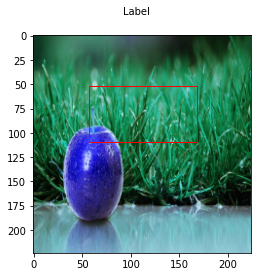

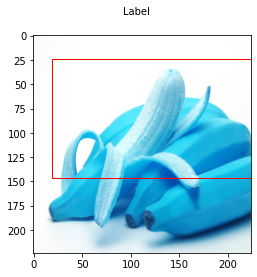

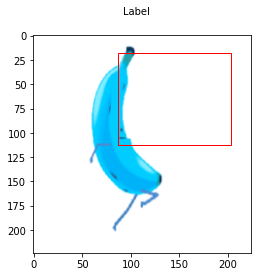

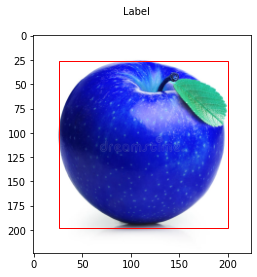

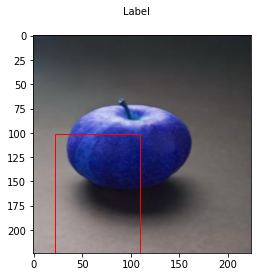

In [21]:
#validating the resized annotation by visualisation
for i in range(5):
  fig,ax = plt.subplots()
  fig.suptitle("Label".format(train_labels[i]), fontsize=10)
  ax.imshow(train_features[i])
  xA,yA,xB,yB = train_coordinates[i]
  rect = patches.Rectangle((xA,yA),xB-xA,yB-yA, linewidth=1, edgecolor='r',facecolor='none')
  ax.add_patch(rect)

In [9]:
!nvidia-smi

Mon Mar  1 10:01:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [67]:
#creating model architecture
def MobileNetv1(input_shape, n_coor, number_classes):
   #depth wise convolution block definition
    def depthwise_convolutionBlock(InputTensor, pointwise_filter_size, stride):
    #Depthwise layer
        x = DepthwiseConv2D(3,stride,padding='same')(InputTensor)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        #Pointwise layer
        x = Conv2D(pointwise_filter_size,1)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x

    Model_input = Input(input_shape)
    x = Conv2D(32,3,2,padding='same')(Model_input)
    #Batch normalisation and ReLU activation after each convolution are mandatory for non-linearity and avoiding co-variance shift
    x = BatchNormalization()(x)
    x = ReLU()(x)
    print(x)
    #now stacking depthwise conv block as per Mobilenet paper
    x = depthwise_convolutionBlock(x,64,1)
    print(x)
    x = depthwise_convolutionBlock(x,128,2)
    x = Dropout(0.2)(x)
    x = depthwise_convolutionBlock(x,128,1)
    x = depthwise_convolutionBlock(x,256,2)
    x = Dropout(0.2)(x)
    x = depthwise_convolutionBlock(x,256,1)
    x = Dropout(0.2)(x)
    x = depthwise_convolutionBlock(x,512,2)
    for i in range(5):
        x = depthwise_convolutionBlock(x,512,1)
        x = depthwise_convolutionBlock(x,1024,1)
        x = depthwise_convolutionBlock(x,1024,1)
    #Adding average pooling 2D layer
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    #4 coordinates
    bbox_coordinates = Dense(4, activation = 'linear', name = 'regressor')(x)
    #x = GlobalAveragePooling2D()
    # full connected i.e dense layer
    logits = Dense(number_classes, activation='softmax', name='classifier')(x)
    
    model = Model(inputs = Model_input, outputs = [bbox_coordinates,logits])
    return model

In [68]:
Input_shape = 224,224,3
num_classes = 3
n_coor = 4
model = MobileNetv1(Input_shape,n_coor,num_classes)
model.summary()
#dense_6 is the output of regression:: bbox end
# dense_7 is the output of classification end

KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 32), dtype=tf.float32, name=None), name='re_lu_48/Relu:0', description="created by layer 're_lu_48'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 64), dtype=tf.float32, name=None), name='re_lu_50/Relu:0', description="created by layer 're_lu_50'")
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 112, 112, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 112, 112, 32) 128         conv2d_2

In [69]:
#compiling model with loss functions
init_lr = 0.0001
epochs = 100
opt = Adam(lr=init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt, 
              loss={'regressor':'mse','classifier':'categorical_crossentropy'}, 
              metrics={'regressor':'accuracy','classifier':'accuracy'})

In [70]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Dataset/checkpoint", monitor='val_loss')]
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(train_features,[train_coordinates,train_labels],batch_size = 1,epochs = 100,verbose=1,callbacks=[callbacks], validation_data=(val_features, [val_coordinates,val_labels]),shuffle=True, validation_batch_size=32 ,use_multiprocessing=True,workers=12 )

Epoch 1/100
238/238 [==============================] - 10s 26ms/step - loss: 23357.4932 - regressor_loss: 23356.3227 - classifier_loss: 1.1666 - regressor_accuracy: 0.1901 - classifier_accuracy: 0.2627 - val_loss: 24499.3770 - val_regressor_loss: 24498.2695 - val_classifier_loss: 1.1091 - val_regressor_accuracy: 0.2881 - val_classifier_accuracy: 0.3220
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Dataset/checkpoint/assets
Epoch 2/100
238/238 [==============================] - 5s 22ms/step - loss: 21769.8268 - regressor_loss: 21768.6943 - classifier_loss: 1.1328 - regressor_accuracy: 0.7122 - classifier_accuracy: 0.3181 - val_loss: 21591.2109 - val_regressor_loss: 21589.8750 - val_classifier_loss: 1.3376 - val_regressor_accuracy: 0.7119 - val_classifier_accuracy: 0.3220
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Dataset/checkpoint/assets
Epoch 3/100
238/238 [==============================] - 5s 23ms/step - loss: 19270.8740 - re

In [71]:
#saving the model
model.save("FruitDetector.h5")

### 2. Inference Stage.

In [72]:
from google.colab import files
uploaded = files.upload()

Saving Test4.jpg to Test4.jpg
Saving Test3.jpg to Test3.jpg
Saving Test1.jpg to Test1.jpg
Saving Test2.jpg to Test2 (1).jpg


Test1.jpg
Test2.jpg
Test3.jpg
Test4.jpg


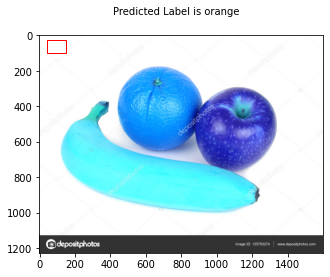

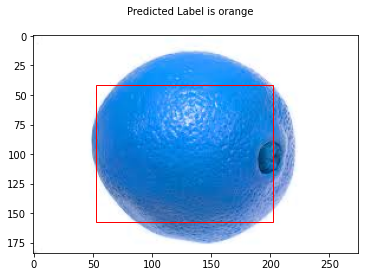

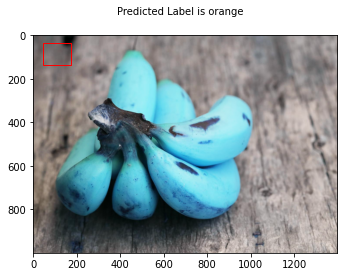

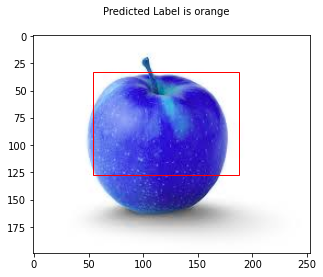

In [76]:
#prediction stage
image_list = []
image_list.append('Test1.jpg')
image_list.append('Test2.jpg')
image_list.append('Test3.jpg')
image_list.append('Test4.jpg')
for orig_image in image_list:
  print(orig_image)
  orig_image = cv2.imread(orig_image)
  image = cv2.resize(orig_image,(224,224),interpolation = cv2.INTER_AREA)
  image = np.reshape(image,(1,224,224,3))
  #np.shape(image))
  out_tensor = model.predict(image)
  #finding the class_label
  LabelDict = {0:"apple",1:"banana", 2:"orange"}
  class_label = LabelDict[np.argmax(out_tensor[1])]
  xA,yA,xB,yB= out_tensor[0][0]
  #visualising
  fig,ax = plt.subplots()
  fig.suptitle("Predicted Label is {}".format(class_label), fontsize=10)
  ax.imshow(orig_image)
  rect = patches.Rectangle((xA,yA),xB-xA,yB-yA, linewidth=1, edgecolor='r',facecolor='none')
  ax.add_patch(rect)


1